In [1]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/High.zip" "High.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Low.zip" "Low.zip"
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/Normal.zip" "Normal.zip"

In [6]:
!mkdir CRC_data

In [10]:
%cp -av Normal CRC_data

'Normal' -> 'CRC_data/Normal'
'Normal/Patient_011_01_Normal.png' -> 'CRC_data/Normal/Patient_011_01_Normal.png'
'Normal/Patient_011_02_Normal.png' -> 'CRC_data/Normal/Patient_011_02_Normal.png'
'Normal/Patient_011_03_Normal.png' -> 'CRC_data/Normal/Patient_011_03_Normal.png'
'Normal/Patient_011_04_Normal.png' -> 'CRC_data/Normal/Patient_011_04_Normal.png'
'Normal/Patient_012_01_Normal.png' -> 'CRC_data/Normal/Patient_012_01_Normal.png'
'Normal/Patient_013_01_Normal.png' -> 'CRC_data/Normal/Patient_013_01_Normal.png'
'Normal/Patient_013_02_Normal.png' -> 'CRC_data/Normal/Patient_013_02_Normal.png'
'Normal/Patient_013_03_Normal.png' -> 'CRC_data/Normal/Patient_013_03_Normal.png'
'Normal/Patient_013_04_Normal.png' -> 'CRC_data/Normal/Patient_013_04_Normal.png'
'Normal/Patient_013_05_Normal.png' -> 'CRC_data/Normal/Patient_013_05_Normal.png'
'Normal/Patient_014_01_Normal.png' -> 'CRC_data/Normal/Patient_014_01_Normal.png'
'Normal/Patient_014_02_Normal.png' -> 'CRC_data/Normal/Patient_014_0

In [15]:
!rm -rf Normal

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Inceptionblock(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool):
        super().__init__()

        # convolution: 1x1 
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1  -> convolution: 3x3 
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1 -> convolution: 5x5
        # Two 3x3 stacked convolution filters used
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        # pooling: 3x3 -> convolution: 1x1
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool, kernel_size=1),
            nn.BatchNorm2d(pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=3):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        
        self.a3 = Inceptionblock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inceptionblock(256, 128, 128, 192, 32, 96, 64)

        # The Inception network consists of inception modules stacked upon each other, with occasional max-pooling layers
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inceptionblock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inceptionblock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inceptionblock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inceptionblock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inceptionblock(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inceptionblock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inceptionblock(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function



In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('CRC_data/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['High' 'Low' 'Normal']


In [20]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [21]:
batch_size_train = 10 # We use a small batch size here for training

batch_size_val = 10

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('CRC_data/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('CRC_data/', val_files, val_classes, 
                         transforms=image_transform)


#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)



Label: Normal


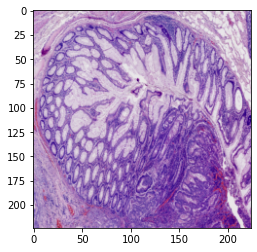

In [22]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [23]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 100


for i in range(1):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GoogleNet().to(device)
  learning_rate = 0.00005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("GoogleNet9SGD.pth"):
        os.remove("GoogleNet9SGD.pth")
      torch.save(model.state_dict(), 'GoogleNet9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GoogleNet().to(device)
  model.load_state_dict(torch.load('GoogleNet9SGD.pth', map_location=device))
  model=model.to(device)
  
 
print(acc)

Experiment:  1
1


<ipython-input-18-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 1.1115

Test: Average loss: 1.0935, Accuracy: 11/42 (26.19%)

2


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 1.0968

Test: Average loss: 1.0831, Accuracy: 11/42 (26.19%)

3


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 1.0437

Test: Average loss: 1.0683, Accuracy: 21/42 (50.00%)

4


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 1.0137

Test: Average loss: 1.0510, Accuracy: 21/42 (50.00%)

5


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 1.0064

Test: Average loss: 1.0320, Accuracy: 21/42 (50.00%)

6


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.9598

Test: Average loss: 1.0228, Accuracy: 22/42 (52.38%)

7


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.9671

Test: Average loss: 0.9938, Accuracy: 22/42 (52.38%)

8


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.9165

Test: Average loss: 0.9532, Accuracy: 23/42 (54.76%)

9


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.9262

Test: Average loss: 0.9215, Accuracy: 23/42 (54.76%)

10


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.9115

Test: Average loss: 0.8944, Accuracy: 24/42 (57.14%)

11


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8954

Test: Average loss: 0.8772, Accuracy: 24/42 (57.14%)

12


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8531

Test: Average loss: 0.8557, Accuracy: 26/42 (61.90%)

13


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8719

Test: Average loss: 0.8416, Accuracy: 27/42 (64.29%)

14


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8494

Test: Average loss: 0.8283, Accuracy: 28/42 (66.67%)

15


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8276

Test: Average loss: 0.8117, Accuracy: 28/42 (66.67%)

16


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8631

Test: Average loss: 0.8001, Accuracy: 29/42 (69.05%)

17


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8408

Test: Average loss: 0.7922, Accuracy: 30/42 (71.43%)

18


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7893

Test: Average loss: 0.7763, Accuracy: 30/42 (71.43%)

19


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8305

Test: Average loss: 0.7664, Accuracy: 30/42 (71.43%)

20


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8163

Test: Average loss: 0.7565, Accuracy: 31/42 (73.81%)

21


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7748

Test: Average loss: 0.7477, Accuracy: 31/42 (73.81%)

22


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7646

Test: Average loss: 0.7352, Accuracy: 31/42 (73.81%)

23


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7925

Test: Average loss: 0.7105, Accuracy: 31/42 (73.81%)

24


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7611

Test: Average loss: 0.7070, Accuracy: 31/42 (73.81%)

25


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.8004

Test: Average loss: 0.6940, Accuracy: 31/42 (73.81%)

26


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7578

Test: Average loss: 0.6867, Accuracy: 32/42 (76.19%)

27


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7647

Test: Average loss: 0.6846, Accuracy: 33/42 (78.57%)

28


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7148

Test: Average loss: 0.6710, Accuracy: 33/42 (78.57%)

29


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7114

Test: Average loss: 0.6538, Accuracy: 33/42 (78.57%)

30


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7639

Test: Average loss: 0.6425, Accuracy: 33/42 (78.57%)

31


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6887

Test: Average loss: 0.6397, Accuracy: 34/42 (80.95%)

32


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7679

Test: Average loss: 0.6276, Accuracy: 34/42 (80.95%)

33


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6798

Test: Average loss: 0.6277, Accuracy: 35/42 (83.33%)

34


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6364

Test: Average loss: 0.6302, Accuracy: 34/42 (80.95%)

35


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6929

Test: Average loss: 0.6047, Accuracy: 35/42 (83.33%)

36


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6678

Test: Average loss: 0.6013, Accuracy: 35/42 (83.33%)

37


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6609

Test: Average loss: 0.5971, Accuracy: 36/42 (85.71%)

38


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.7000

Test: Average loss: 0.5817, Accuracy: 36/42 (85.71%)

39


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6352

Test: Average loss: 0.5775, Accuracy: 36/42 (85.71%)

40


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6691

Test: Average loss: 0.5789, Accuracy: 36/42 (85.71%)

41


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6313

Test: Average loss: 0.5673, Accuracy: 36/42 (85.71%)

42


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6369

Test: Average loss: 0.5605, Accuracy: 36/42 (85.71%)

43


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6204

Test: Average loss: 0.5541, Accuracy: 36/42 (85.71%)

44


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.6378

Test: Average loss: 0.5436, Accuracy: 36/42 (85.71%)

45


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5383

Test: Average loss: 0.5273, Accuracy: 37/42 (88.10%)

46


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5714

Test: Average loss: 0.5299, Accuracy: 36/42 (85.71%)

47


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5652

Test: Average loss: 0.5207, Accuracy: 36/42 (85.71%)

48


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5911

Test: Average loss: 0.5107, Accuracy: 36/42 (85.71%)

49


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5923

Test: Average loss: 0.5074, Accuracy: 36/42 (85.71%)

50


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5477

Test: Average loss: 0.5138, Accuracy: 36/42 (85.71%)

51


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5350

Test: Average loss: 0.5028, Accuracy: 36/42 (85.71%)

52


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5347

Test: Average loss: 0.5059, Accuracy: 37/42 (88.10%)

53


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5786

Test: Average loss: 0.4953, Accuracy: 37/42 (88.10%)

54


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5266

Test: Average loss: 0.4983, Accuracy: 37/42 (88.10%)

55


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5490

Test: Average loss: 0.4949, Accuracy: 37/42 (88.10%)

56


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5639

Test: Average loss: 0.4841, Accuracy: 36/42 (85.71%)

57


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4977

Test: Average loss: 0.4717, Accuracy: 37/42 (88.10%)

58


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5346

Test: Average loss: 0.4741, Accuracy: 37/42 (88.10%)

59


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4573

Test: Average loss: 0.4693, Accuracy: 37/42 (88.10%)

60


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4986

Test: Average loss: 0.4651, Accuracy: 37/42 (88.10%)

61


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4654

Test: Average loss: 0.4636, Accuracy: 38/42 (90.48%)

62


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.5641

Test: Average loss: 0.4506, Accuracy: 36/42 (85.71%)

63


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4734

Test: Average loss: 0.4513, Accuracy: 38/42 (90.48%)

64


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4570

Test: Average loss: 0.4445, Accuracy: 38/42 (90.48%)

65


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4546

Test: Average loss: 0.4340, Accuracy: 37/42 (88.10%)

66


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4344

Test: Average loss: 0.4124, Accuracy: 37/42 (88.10%)

67


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4537

Test: Average loss: 0.4238, Accuracy: 38/42 (90.48%)

68


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4374

Test: Average loss: 0.4116, Accuracy: 38/42 (90.48%)

69


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4373

Test: Average loss: 0.4073, Accuracy: 38/42 (90.48%)

70


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4329

Test: Average loss: 0.3947, Accuracy: 38/42 (90.48%)

71


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4519

Test: Average loss: 0.3970, Accuracy: 38/42 (90.48%)

72


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3927

Test: Average loss: 0.3841, Accuracy: 38/42 (90.48%)

73


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4199

Test: Average loss: 0.3744, Accuracy: 37/42 (88.10%)

74


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4202

Test: Average loss: 0.3844, Accuracy: 38/42 (90.48%)

75


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4016

Test: Average loss: 0.3849, Accuracy: 37/42 (88.10%)

76


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3858

Test: Average loss: 0.3757, Accuracy: 38/42 (90.48%)

77


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4249

Test: Average loss: 0.3545, Accuracy: 37/42 (88.10%)

78


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3782

Test: Average loss: 0.3617, Accuracy: 38/42 (90.48%)

79


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3597

Test: Average loss: 0.3523, Accuracy: 37/42 (88.10%)

80


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4455

Test: Average loss: 0.3543, Accuracy: 38/42 (90.48%)

81


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3736

Test: Average loss: 0.3558, Accuracy: 37/42 (88.10%)

82


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3789

Test: Average loss: 0.3686, Accuracy: 38/42 (90.48%)

83


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.4037

Test: Average loss: 0.3534, Accuracy: 38/42 (90.48%)

84


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3940

Test: Average loss: 0.3525, Accuracy: 38/42 (90.48%)

85


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3687

Test: Average loss: 0.3238, Accuracy: 38/42 (90.48%)

86


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3446

Test: Average loss: 0.3266, Accuracy: 38/42 (90.48%)

87


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3547

Test: Average loss: 0.3310, Accuracy: 38/42 (90.48%)

88


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3069

Test: Average loss: 0.3274, Accuracy: 38/42 (90.48%)

89


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3289

Test: Average loss: 0.3065, Accuracy: 39/42 (92.86%)

90


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3266

Test: Average loss: 0.2954, Accuracy: 39/42 (92.86%)

91


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3534

Test: Average loss: 0.2985, Accuracy: 39/42 (92.86%)

92


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3699

Test: Average loss: 0.3036, Accuracy: 37/42 (88.10%)

93


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3240

Test: Average loss: 0.2964, Accuracy: 39/42 (92.86%)

94


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.2895

Test: Average loss: 0.3017, Accuracy: 39/42 (92.86%)

95


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3694

Test: Average loss: 0.2853, Accuracy: 39/42 (92.86%)

96


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3085

Test: Average loss: 0.2816, Accuracy: 38/42 (90.48%)

97


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3305

Test: Average loss: 0.2712, Accuracy: 37/42 (88.10%)

98


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.2811

Test: Average loss: 0.2716, Accuracy: 39/42 (92.86%)

99


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.2936

Test: Average loss: 0.2842, Accuracy: 39/42 (92.86%)

100


  0%|          | 0/10 [00:00<?, ?it/s]

Train: Average loss: 0.3050

Test: Average loss: 0.2556, Accuracy: 39/42 (92.86%)

92.85714285714286
